<a target="_blank" href="https://colab.research.google.com/github/sonder-art/automl_o23/blob/main/codigo/intro_ml/train_val_test_regularization.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Regularizacion y Validacion

Ahora estudiaremos como funciona la regularizacion, y como se ve la convergencia de los parametros.

Basado en [este codigo](https://colab.research.google.com/github/cvxgrp/cvxpy/blob/master/examples/machine_learning/ridge_regression.ipynb#scrollTo=MHUqiFdmw6-y).

In [94]:
# !pip install cvxpy
# !pip install -U scikit-learn
# !pip install pandas
# !pip install seaborn

In [95]:
import cvxpy as cp
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(rc={'figure.figsize':(16,6)})

In [96]:
def fun_perdida(X, Y, beta):
    return cp.pnorm(cp.matmul(X, beta) - Y, p=2)**2

def penalizacion(beta):
    return cp.pnorm(beta, p=2)**2

def fun_objetivo(X, Y, beta, lambd):
    return fun_perdida(X, Y, beta) + lambd * penalizacion(beta)

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * fun_perdida(X, Y, beta).value

In [97]:
def generate_data(m=100, n=20, sigma=5):
    "Generates data matrix X and observations Y."
    np.random.seed(8939)
    beta_star =  np.random.lognormal(0,1,size=(n,))*5
    X = np.random.normal(10,1,size=(m, n))
    eps = np.random.normal(10,1,size=m)
    Y = X.dot(beta_star) + eps
    return X, Y , beta_star

In [98]:
def plot_errors(train_errors, val_errors, test_errors, lambd_values):
    sns.lineplot(x=lambd_values, y=train_errors, label="Train error")
    sns.lineplot(x=lambd_values, y=val_errors, label="Val error")
    sns.lineplot(x=lambd_values, y=test_errors, label="Test error")
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    lmb_opt = val_errors.index(min(val_errors))
    lmb_opt = lambd_values[lmb_opt]
    test_opt = test_errors.index(min(test_errors))
    test_opt = lambd_values[test_opt]
    plt.axvline(lmb_opt, color='orange')
    plt.axvline(test_opt, color='g')
    plt.show()

In [99]:
def plot_regularization_path(lambd_values, beta_values):
    num_coeffs = len(beta_values[0])
    for i in range(num_coeffs):
        sns.lineplot(x=lambd_values, y=[wi[i] for wi in beta_values])
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()


Modelo real:  
$y = X\beta + \epsilon$  
$\beta \in \mathcal{R}^n$  
 $X \in \mathcal{R}^{m \times n}$
  
Modelo $\hat{f}$ propuesto:  
$\hat{f} = X\beta + X^2\beta^I +  
X^{\frac{1}{2}}\beta^{II} + \epsilon$

En este caso agregamos transformaciones de variables cubicas y raices a nuestro modelo. Aunque, originalemnte no existian.

In [100]:
m = 200
n = 5
noise = 3
sigma = 5


X, Y, real_beta = generate_data(m, n, sigma)

# Creacion de Ruido
n_ = n
# X_noise = np.random.normal(1,5, size=(m,noise))
# X = np.concatenate((X, X_noise), axis=1)
#real_beta = np.concatenate((real_beta, np.zeros(noise)))
# n = n +noise
# ### Transformaciones cubicas y raiz.
for x in range(0,n):
    X = np.concatenate((X,np.power(X[:,x],3).reshape((m,1))), axis=1)
for x in range(0,n):
    X = np.concatenate((X,np.power(X[:,x],.5).reshape((m,1))), axis=1)

real_beta = np.concatenate((real_beta, np.zeros( X.shape[1]-n)))
n = X.shape[1]


# df = pd.DataFrame(X_t[:,0:n_])
# df['y'] = Y_t
# sns.pairplot(df)

Plateemos el problema de optimizacion:

In [101]:
# Split Test Train
X_t, X_test, Y_t, Y_test = train_test_split(
X, Y, test_size=0.2, random_state=48)
# Split Train Validation
X_train, X_val, Y_train, Y_val = train_test_split(
X_t, Y_t, test_size=0.5, random_state=420)

# Numero de betas
beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(fun_objetivo(X_train, Y_train, beta, lambd)))

lambd_values = np.logspace(-10, 1, 100)
train_errors = []
val_errors = []
test_errors = []
beta_values = []
# Resolver regresion lineal para cada lambda
for v in lambd_values:
    lambd.value = v
    problem.solve()
    train_errors.append(mse(X_train, Y_train, beta))
    val_errors.append(mse(X_val, Y_val, beta))
    test_errors.append(mse(X_test, Y_test, beta))
    beta_values.append(beta.value)

/home/uumami/miniconda3/envs/itam/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


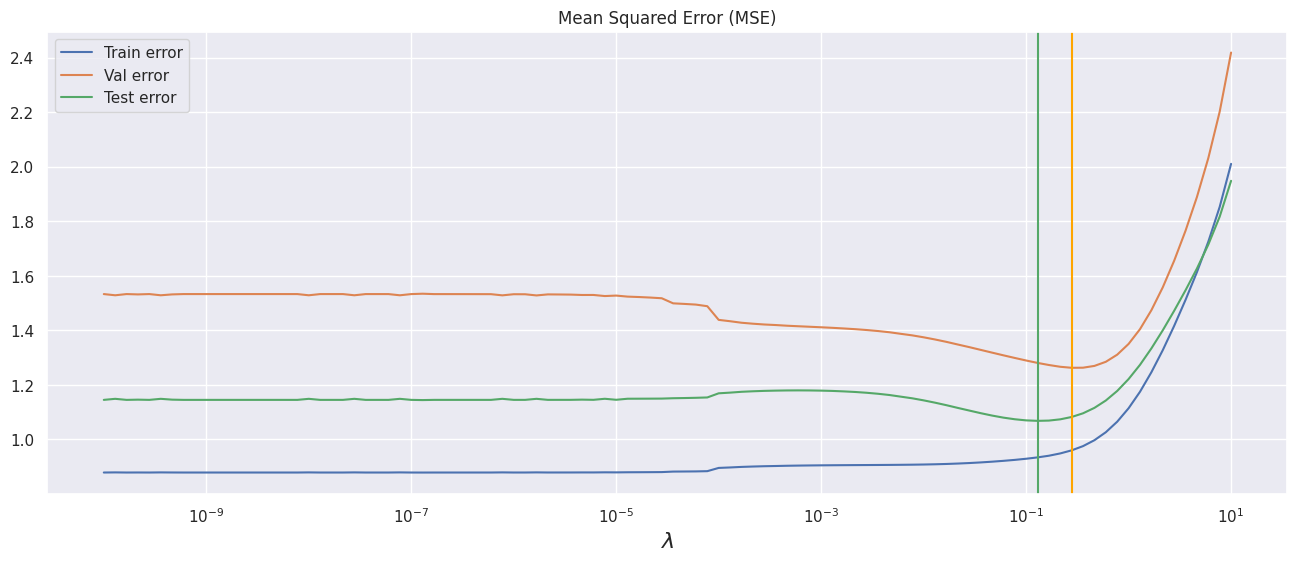

In [102]:
plot_errors(train_errors, val_errors, test_errors, lambd_values)

Dinamica de las $\beta$ dependiendo del valor de $\lambda$

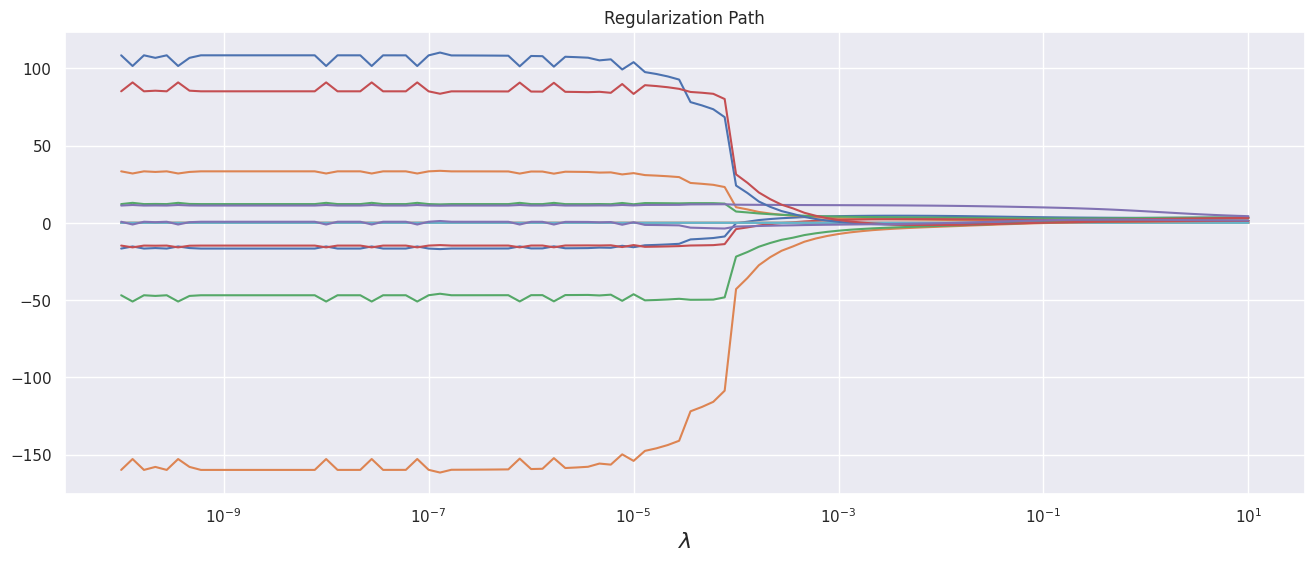

In [103]:
plot_regularization_path(lambd_values, beta_values)

$\beta^*$ optima vs. $\beta$ real

Lambda Optima: 0.2782559402207126


<Axes: xlabel='beta_real', ylabel='beta_opt'>

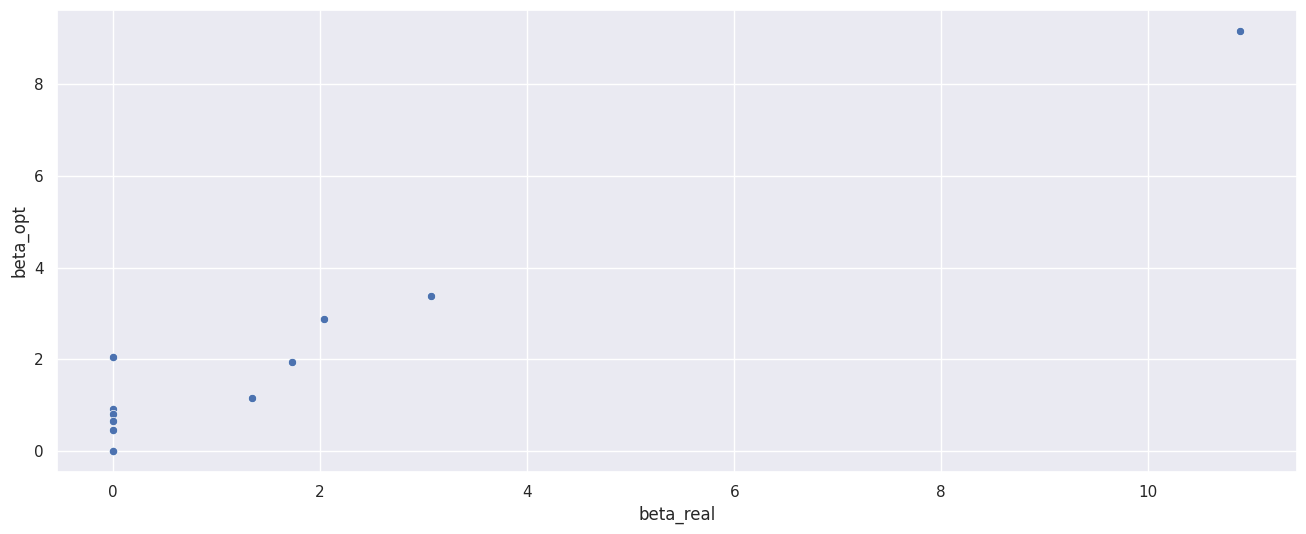

In [104]:
lmb_opt = val_errors.index(min(val_errors))
print(f'Lambda Optima: {lambd_values[lmb_opt]}')
betas = pd.DataFrame({'beta_real':real_beta,'beta_opt':beta_values[lmb_opt]})
sns.scatterplot(data=betas, y='beta_opt', x='beta_real')

# Regularizacion con entrenamiento

Ahora estudiemos como funciona la regularizacion en la paqueteria de `sklearn`. Para ello importamos el modelo `lasso` que en vez de tener una penalizacion cuadratica, la tiene como valor absoluto. Dado esto, nos ayuda a quitar variables que no nos sirven, pues convierte los valores de los coeficientes en cero

In [105]:
# Importing necessary libraries
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


## Ejemplo naive

Creemos una regresion sencilla $Y=XB + e$

In [106]:
# Creating a sample dataset
X, y = make_regression(n_samples=500, n_features=100, noise=0.5, random_state=42)

Separemos en train, validation y test

In [107]:
# Splitting the data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

Elijamos varios valores para `alpha` para entender como se esta comportando el modelo.  

Podriamos utilizar un grid, o podriamos sacar valores de una distribucion como la `logspace` que son valores uniformemente distribuidos en escala logaritmica.

/tmp/ipykernel_15629/621873013.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(alphas)


<Axes: ylabel='Density'>

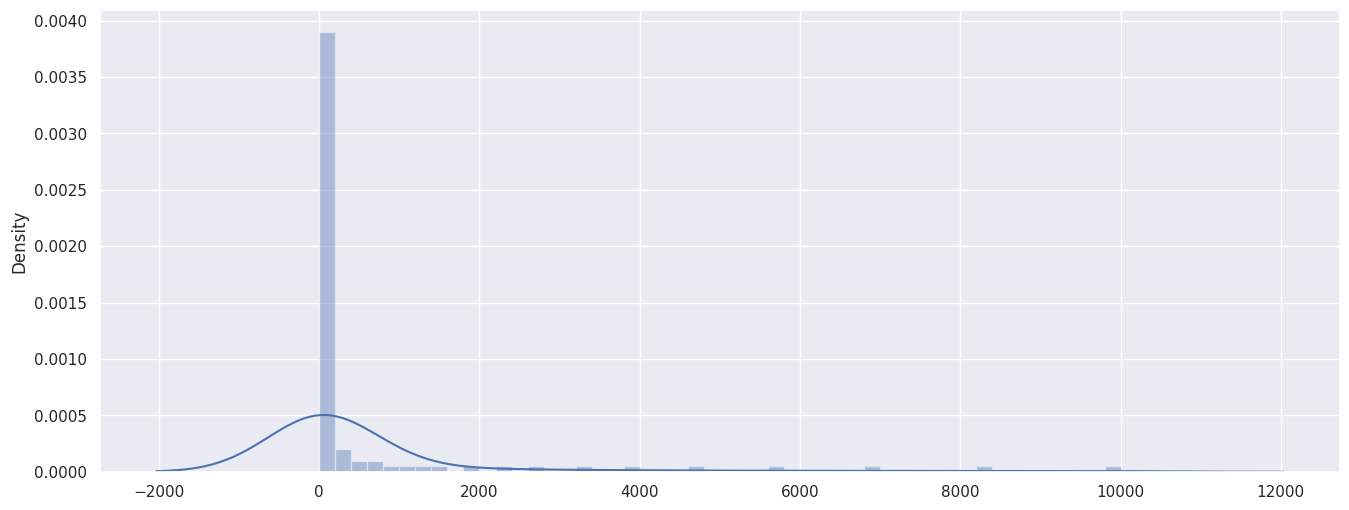

In [108]:
# Exploring a range of alpha values
alphas = np.logspace(-4, 4, 100)
sns.distplot(alphas)

Entrenemos varios modelos con las diferentes alphas y comparemos, y usemos la metrica `RMSE`

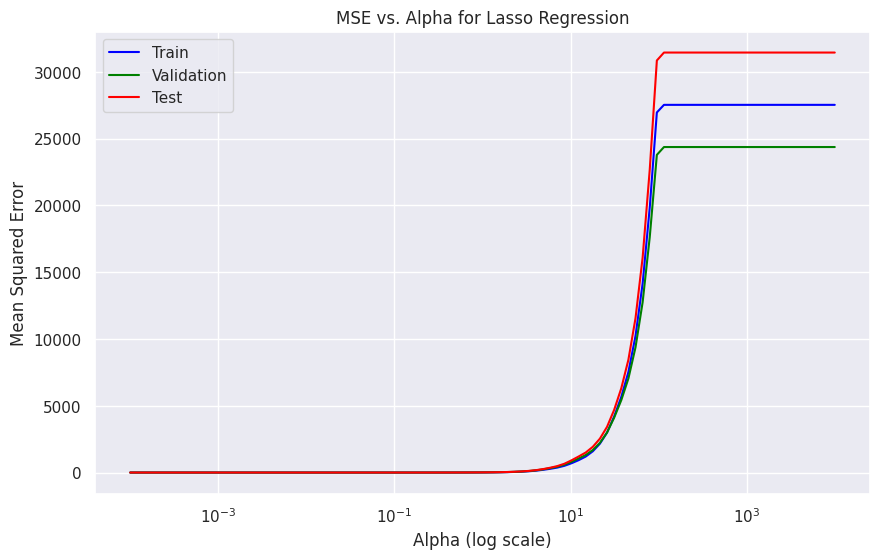

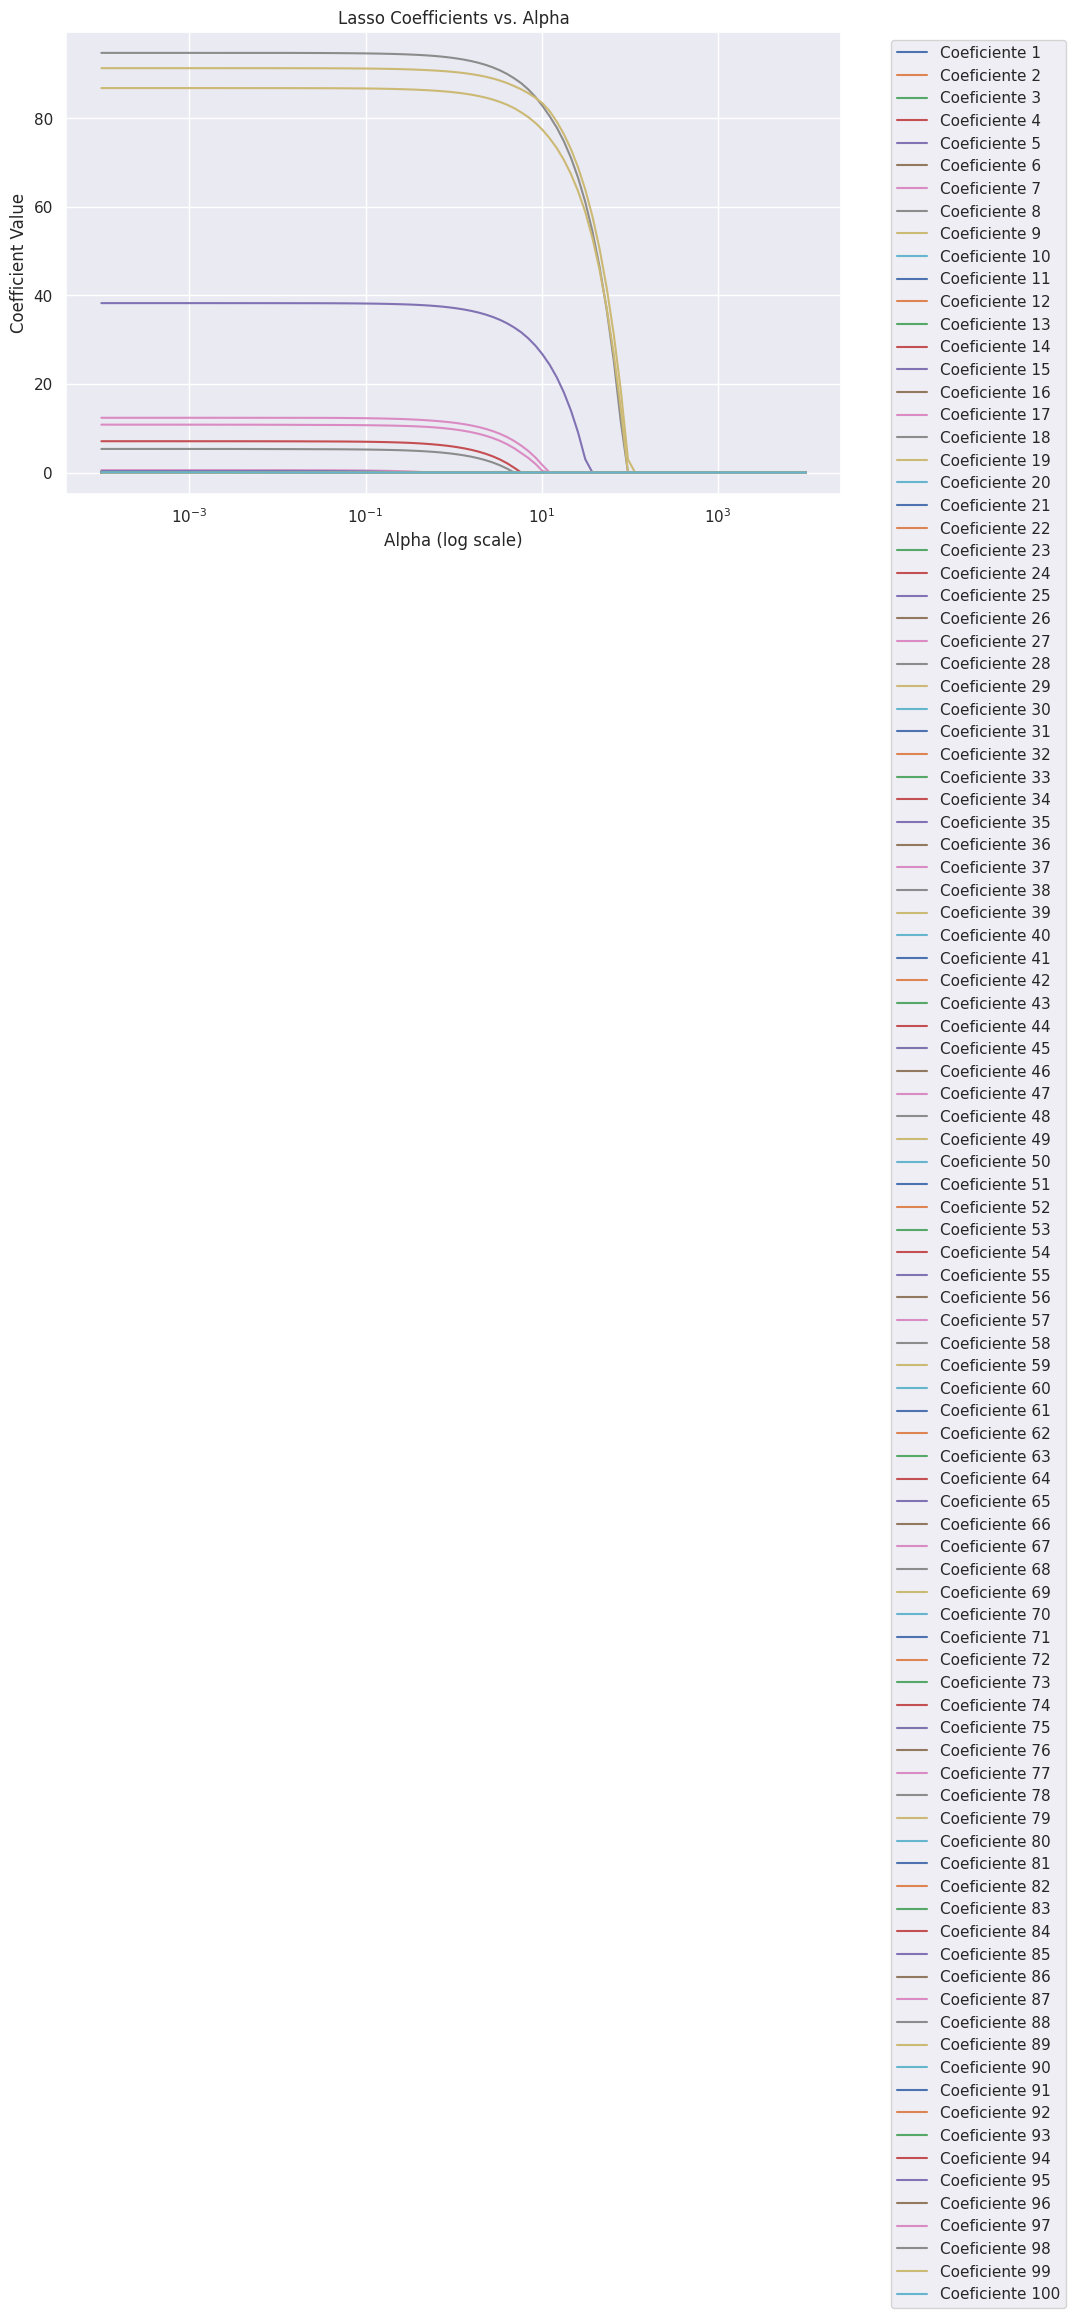

In [109]:
train_errors, val_errors, test_errors = [], [], []

coefficients = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    
    y_train_pred = lasso.predict(X_train)
    y_val_pred = lasso.predict(X_val)
    y_test_pred = lasso.predict(X_test)
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    train_errors.append(train_mse)
    val_errors.append(val_mse)
    test_errors.append(test_mse)
    
    # Almacenamos los coeficientes
    coefficients.append(lasso.coef_)

coefficients = np.array(coefficients)

# Plotting MSEs against alpha values
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_errors, label='Train', color='blue')
plt.plot(alphas, val_errors, label='Validation', color='green')
plt.plot(alphas, test_errors, label='Test', color='red')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. Alpha for Lasso Regression')
plt.legend()
plt.grid(True)
plt.show()

# Plotting coefficients against alpha values
plt.figure(figsize=(10, 6))
for i in range(coefficients.shape[1]):
    plt.plot(alphas, coefficients[:, i], label=f'Coeficiente {i+1}')

plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients vs. Alpha')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()


## Ejemplo mas complejo


In [110]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

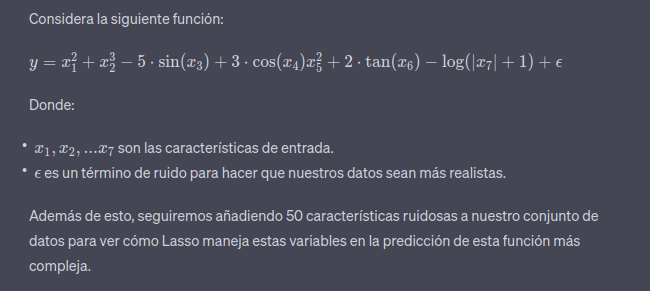

In [111]:
# Generando el conjunto de datos
np.random.seed(422)
n_samples = 1000

X = np.random.rand(n_samples, 7) * 100 - 5  # Valores aleatorios entre -50 y 50

# Elige alguna de las siguientes funciones

y = (X[:, 0]**2 + X[:, 1]**3 - 5 * np.sin(X[:, 2]) + 3 * np.cos(X[:, 3]) * X[:, 4]**2
     + 2 * np.tan(X[:, 5]) - np.log(np.abs(X[:, 6]) + 1))

# y = (X[:, 0]**2 + X[:, 1]**3 - 15 * X[:, 2] + 30 * X[:, 3] * X[:, 4]**2
#      + 21 *X[:, 5] - np.log(np.abs(X[:, 6]) + 1)) + np.random.normal(1,5,X.shape[0])

# Añadiendo ruido gaussiano
y += np.random.normal(0, 100, size=y.shape)

Ahora vamos a annadir variables ruidosas o que no tienen que ver con nuestro modelo para ver como se comporta la regresion Lasso

In [112]:
# Añadiendo 50 características ruidosas
noisy_features = np.random.randn(n_samples, 5)
X = np.hstack([X, noisy_features])

In [113]:
# Dividiendo los datos en conjuntos de entrenamiento, validación y prueba
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [114]:
# Explorando una gama de valores de alpha
alphas = np.logspace(-6, 6, 100)

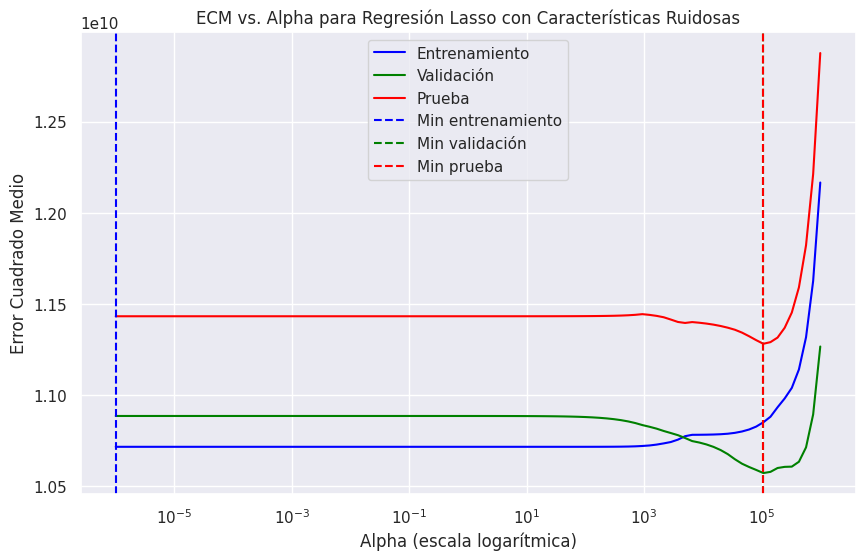

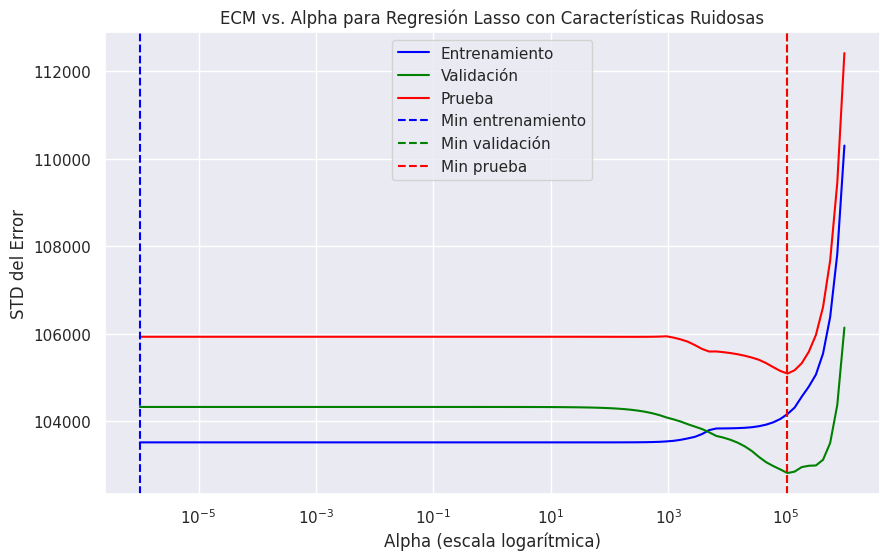

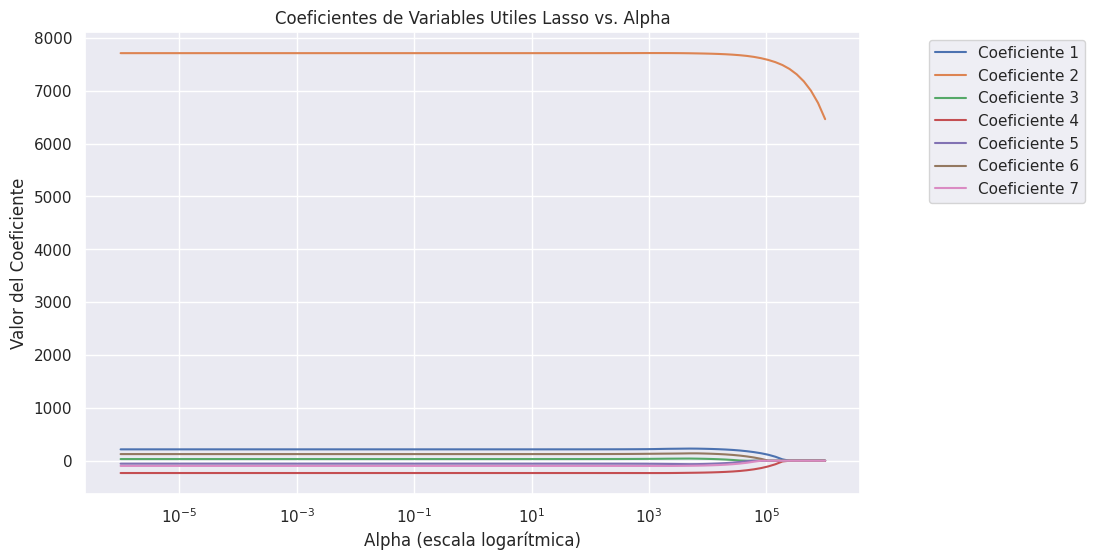

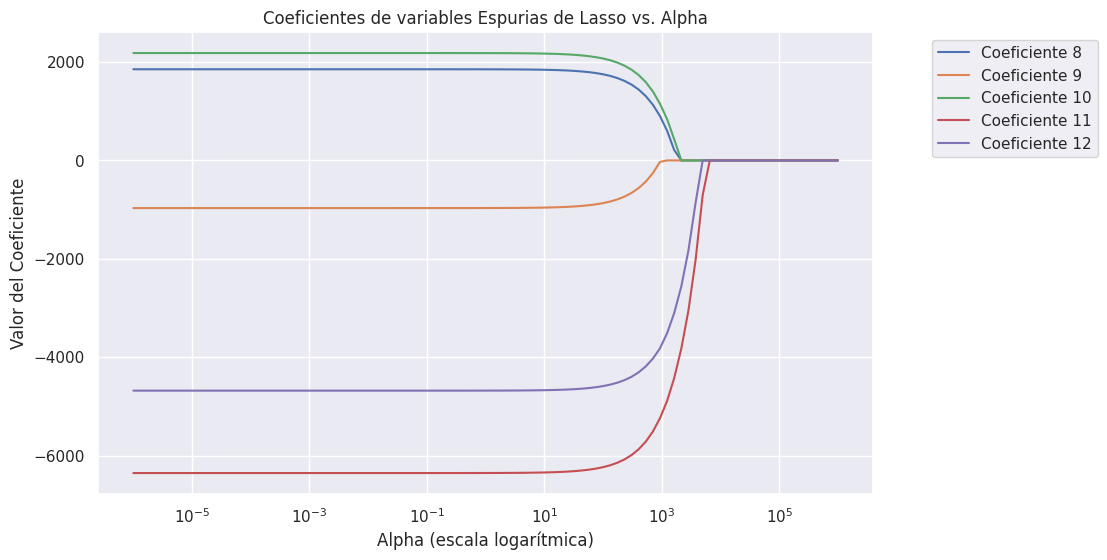

In [116]:
train_errors, val_errors, test_errors = [], [], []
train_stds, val_stds, test_stds = [], [], []

coefficients = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)

    y_train_pred = lasso.predict(X_train)
    y_val_pred = lasso.predict(X_val)
    y_test_pred = lasso.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_std = np.std(y_train - y_train_pred)
    val_std = np.std(y_val - y_val_pred)
    test_std = np.std(y_test - y_test_pred)

    train_errors.append(train_mse)
    val_errors.append(val_mse)
    test_errors.append(test_mse)
    
    train_stds.append(train_std)
    val_stds.append(val_std)
    test_stds.append(test_std)
    
    # Almacenamos los coeficientes
    coefficients.append(lasso.coef_)

coefficients = np.array(coefficients)

# Encontrando los alphas que minimizan los errores
alpha_min_train = alphas[np.argmin(train_errors)]
alpha_min_val = alphas[np.argmin(val_errors)]
alpha_min_test = alphas[np.argmin(test_errors)]

# Graficando los errores MSE en función de los valores de alpha
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_errors, label='Entrenamiento', color='blue')
plt.plot(alphas, val_errors, label='Validación', color='green')
plt.plot(alphas, test_errors, label='Prueba', color='red')

# Agregando las líneas que indican el mínimo error
plt.axvline(x=alpha_min_train, color='blue', linestyle='--', label='Min entrenamiento')
plt.axvline(x=alpha_min_val, color='green', linestyle='--', label='Min validación')
plt.axvline(x=alpha_min_test, color='red', linestyle='--', label='Min prueba')

plt.xscale('log')
plt.xlabel('Alpha (escala logarítmica)')
plt.ylabel('Error Cuadrado Medio')
plt.title('ECM vs. Alpha para Regresión Lasso con Características Ruidosas')
plt.legend()
plt.grid(True)
plt.show()

# Graficando coeficientes en función de los valores de alpha
plt.figure(figsize=(10, 6))
for i in range(0,7):
    plt.plot(alphas, coefficients[:, i], label=f'Coeficiente {i+1}') # Limitar leyendas para visibilidad

plt.xscale('log')
plt.xlabel('Alpha (escala logarítmica)')
plt.ylabel('Valor del Coeficiente')
plt.title('Coeficientes de Variables Utiles Lasso vs. Alpha')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()


# Graficando coeficientes en función de los valores de alpha
plt.figure(figsize=(10, 6))
for i in range(7, coefficients.shape[1]):
    plt.plot(alphas, coefficients[:, i], label=f'Coeficiente {i+1}') # Limitar leyendas para visibilidad

plt.xscale('log')
plt.xlabel('Alpha (escala logarítmica)')
plt.ylabel('Valor del Coeficiente')
plt.title('Coeficientes de variables Espurias de Lasso vs. Alpha')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()
